# XGBoost feature selection
(using stratified 5-fold cross validation)

Remove stroke_team (and stroke_team_id)

### Plain English summary
Machine learning algorithms (such as XGBoost) were devised to deal with enormous and complex datasets, with the approach that the more data that you can throw at them, the better, and let the algorithms work it out themselves.

However this approach can make it tricky to be able to explain a coherent story about how the models are working, the relationships that they have found, and how they have made their predictions.

Our machine learning work has taken on an additional focus - to make our work as explainable as possible. Both in terms of being able to explain how the models have arrived at their outcome, and in the ease at which we can disseminate our work to a wider audience. For us to have explainable models we want to have a balance between model complexity and model accuracy in order to be able to explain our models, whilst maintaining model performance.

In this notebook we create a model to predict the disability level of a patient who had a stroke, at discharge from inpatient care. Disability is recorded in the SSNAP dataset using the modified Rankin Scale (mRS). The scale runs from 0–6, running from perfect health without symptoms to death. The model returns a probability score of the patient being in each of these seven mRS levels. This is known as a multiclass classification problem. The patient is predicted to have the mRS level with the highest probability.

We train a model using just a single input feature, chosen as the feature that gave the model it's best performance (based on ROCAUC). 

Here we rerun this experiment, excluding the choice of "stroke team". Compare with notebook 020_xgb_5fold_feature_selection.ipynb.

The single feature that gave the best model performance was "prior disability". Fixing this feature in the model, we repeated the process to chose the next single feature to add to the model. The best single feature to include next was "Stroke severity". We repeated this process, choosing the next feature to add to the model until 25 features were included (it was limited to 25 features for computational time purposes).

We found that a model with eight features is able to provide 99.6% of the accuracy obtained when all 56 features are used (ROCAUC: 0.786). A model with 16 features matched the performance of the model with all of the features (to 3 dp).

These eight features are largely independent of each other (refer to notebook check correlation between selected features to confirm this).

The first 8 features selected are: 
Feature  1: prior_disability, AUC: 0.687
Feature  2: stroke_severity, AUC: 0.770
Feature  3: age, AUC: 0.777
Feature  4: nihss_arrival_loc, AUC: 0.779
Feature  5: scan_to_thrombolysis_time, AUC: 0.780
Feature  6: thrombolysis_no_but_improving, AUC: 0.782
Feature  7: nihss_arrival_best_language, AUC: 0.783
Feature  8: thrombolysis_no_but_other_medical, AUC: 0.783

(by comparision, here is the resutl when stroke team is an option (from notebook 020):
Feature  1: prior_disability, AUC: 0.687
Feature  2: stroke_severity, AUC: 0.770
Feature  3: stroke_team, AUC: 0.800
Feature  4: age, AUC: 0.806
Feature  5: year, AUC: 0.811
Feature  6: nihss_arrival_loc, AUC: 0.814
Feature  7: scan_to_thrombolysis_time, AUC: 0.816
Feature  8: thrombolysis_no_but_improving, AUC: 0.817

Notice how the feature Year is not selected when Stroke Team was not an option to be selected.

### Model and data
XGBoost models were trained on stratified k-fold cross-validation data. The full dataset contains 58 features that describe the patient (in terms of their clinical characteristics, the stroke pathway, and the stroke team that they attended). Here we removed the stroke team feature. Features to be included in the model were sequentially selected as the single best feature to add to the model in terms of performance from the area under the receiver operating characteristic (ROC AUC) curve. When included, the hospital and weekday feature are included as a one-hot encoded feature.

### Aims
* Select up to 25 features (from the full set of 58 features, excluding stroke team) using forward feature selection. Features are selected sequentially (using the greedy approach), choosing the feature that leads to most improvement in ROC AUC score.
* See what affter this has on the feature chosen

### Observations
* Year is not selected when stroke team is not an option to be selected.

### Follow up work
* To understand the interaction between features "stroke team" and "year", we can make use of the SHAP interaction values. This is when the SHAP values per feature are represented as their sub-parts: their main effect, and all of the pair-wise interactions with the other features. As yet, it is not possible to calculate the SHAP interaction values for a multiclass classification model. So we will explore this using binary models. We create binary models using two formats:

1. Predicting whether a patient will be one side or the other of each mRS threshold (a set of 6 models, i. mRS0 vs mRS1+ ii. <mRS2 or >mRS1 iii. <mRS3 or >mRS2 iV. <mRS4 or >mRS3 V. <mRS5 or >mRS4 Vi. <mRS6 or >mRS5).
1. Predict whether a patient is a specifc class, or the rest (a set of 6 models, i. mRS0 vs rest ii. mRS2 vs rest iii. mRS3 vs rest iV. mRS4 vs rest V. mRS5 vs rest Vi. mRS6 vs rest.

(Orinigally called 02a_xgb_5fold_feature_selection.ipynb)

## Import libraries

In [20]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

from sklearn.metrics import confusion_matrix

#import seaborn as sns

from sklearn.metrics import roc_auc_score

import time

Report the time duration to run notebook

In [21]:
start_time = time.time()

## Set up paths and filenames
Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [22]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    notebook: str = '021_'

paths = Paths()

Create output folders if needed

In [ ]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

In [23]:
n_kfold = 5

## Import data

Data has previously been split into 5 stratified k-fold splits.

In [24]:
def drop_columns(df, cols):
    for col in cols:
        if col in df.columns: df.drop([col],axis=1,inplace=True)
    return(df)

In [25]:
cols_remove = ['id','stroke_team', 'stroke_team_id']

In [26]:
train_data, test_data = [], []

for k in range(5):
    filename = os.path.join(paths.data_read_path, 
                                ('03_train_' + str(k) + '.csv'))
    train = pd.read_csv(filename)
    train = drop_columns(train, cols_remove)
    train_data.append(train)

    filename = os.path.join(paths.data_read_path, 
                                ('03_test_' + str(k) + '.csv'))
    test_data.append(pd.read_csv(filename))
    test = drop_columns(test, cols_remove)
    test_data.append(test)

Get list of features

In [27]:
features = list(train_data[0])
print(f"There are {len(features)} features")

There are 56 features


## One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [28]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    df [dataframe]: training or test dataset
    feature_name [str]: feature to convert to ont hot encoding
    prefix [str]: string to use on new feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix = prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Set up two lists for the one hot encoding. 

A list of the feature names that are categorical and to be converted using one hot encoding.
A list of the prefixes to use for these features.

In [29]:
features_to_one_hot = ["stroke_team", "weekday"]
list_prefix = ["team", "weekday"]

For each feature in the list, for each train and test dataset, convert to one hot encoded.

for feature, prefix in zip(features_to_one_hot, list_prefix):
    for k_fold in range(5):
        train_data[k_fold] = convert_feature_to_one_hot(train_data[k_fold], feature, prefix)
        test_data[k_fold] = convert_feature_to_one_hot(test_data[k_fold], feature, prefix)

## Fit XGBoost model

Train model with all features (as comparison)

In [30]:
r_square_kfold = []
roc_auc_ovr_kfold = []
accuracy_kfold = []
error_within_one_kfold = []
feature_importance_kfold = []
y_probs_kfold = []
y_pred_kfold = []
model_kfold = []

# Loop through k folds
for k_fold in range(5):

    # Get k fold split
    train = train_data[k_fold]
    test = test_data[k_fold]

    # Get X and y
    X_train = train.drop('discharge_disability', axis=1)
    X_test = test.drop('discharge_disability', axis=1)
    y_train = train['discharge_disability']
    y_test = test['discharge_disability']

    # One hot encode categorical features
    for feature, prefix in zip(features_to_one_hot, list_prefix):
        if feature in list(X_train):
           X_train = convert_feature_to_one_hot(X_train, feature, prefix)
           X_test = convert_feature_to_one_hot(X_test, feature, prefix)

    # Define model
    model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

    # Fit model
    model.fit(X_train, y_train)
    model_kfold.append(model)
    
    # Get target categories from model
    classes = model.classes_

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_test)
    y_probs_kfold.append(y_probs)

    # Get and store predicted class
    y_pred = model.predict(X_test)
    y_pred_kfold.append(y_pred)

    # Calculate ROC AUC for multiclass models, using One vs Rest
    roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
    roc_auc_ovr_kfold.append(roc_auc_ovr)

    # Calculate error
    y_error = y_test - y_pred
    accuracy = np.mean(y_error==0)
    accuracy_kfold.append(accuracy)

    error_within_one = np.mean(np.abs(y_error)<=1)
    error_within_one_kfold.append(error_within_one)

    # Get and store feature importances
    feature_importance = model.feature_importances_
    feature_importance_kfold.append(feature_importance)

# Get average result from all k-fold splits
roc_auc_ovr_mean = np.mean(roc_auc_ovr_kfold)
accuracy_mean = np.mean(accuracy_kfold)
error_within_one_mean = np.mean(error_within_one_kfold)

print (f'All features, AUC: {roc_auc_ovr_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(roc_auc_ovr_kfold):0.3f})')

print (f'All features, accuracy: {accuracy_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(accuracy_kfold):0.3f})')

print (f'All features, accuracy within one: {error_within_one_mean:0.3f} '
       f'(std across 5 kfolds: {np.std(error_within_one_kfold):0.3f})')

All features, AUC: 0.786 (std across 5 kfolds: 0.001)
All features, accuracy: 0.387 (std across 5 kfolds: 0.003)
All features, accuracy within one: 0.734 (std across 5 kfolds: 0.003)


Check that the five ROC AUC are not identical (to give the stddev 0)

In [31]:
roc_auc_ovr_kfold

[0.7855273126090461,
 0.7863481730544638,
 0.7849990300685709,
 0.7857459876698715,
 0.7865973763787532]

## Fit XGBoost model

Loop through each feature in turn and train an XGBoost model with that feature added to the dataset (for each k-fold split). Choose the single best feature to add to the model in terms of performance from the ROC AUC using one vs rest (mean of the k-fold splits).

Repeat until 25 features have been selected.

In [32]:
# Create list to store accuracies and chosen features
roc_auc_by_feature_number = []
roc_auc_by_feature_number_kfold = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(train_data[0].drop('discharge_disability', axis=1))
number_of_features = len(available_features)

# Loop through number of features
for i in range (25):
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''
    
    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        
        # Set up a list to hold AUC results for this feature for each kfold
        feature_roc_auc_ovr_kfold = []
        
        # Loop through k folds
        for k_fold in range(5):

            # Get k fold split
            train = train_data[k_fold]
            test = test_data[k_fold]

            # Get X and y
            X_train = train.drop('discharge_disability', axis=1)
            X_test = test.drop('discharge_disability', axis=1)
            y_train = train['discharge_disability']
            y_test = test['discharge_disability']
            
            # Restrict features
            X_train = X_train[features_to_use]
            X_test = X_test[features_to_use]

            # One hot encode categorical features
            for cat_feature, prefix in zip(features_to_one_hot, list_prefix):
                if cat_feature in features_to_use:
                    X_train = convert_feature_to_one_hot(X_train, cat_feature, prefix)
                    X_test = convert_feature_to_one_hot(X_test, cat_feature, prefix)

            # Define model
            model = XGBClassifier(verbosity = 0, seed=42, learning_rate=0.5)

            # Fit model
            model.fit(X_train, y_train)

            # Get predicted probabilities
            y_probs = model.predict_proba(X_test)
            
            # Calculate ROC AUC for multiclass models, using One vs Rest
            feature_roc_auc_ovr = roc_auc_score(y_test, y_probs, labels = classes, 
                                multi_class = 'ovr', average = 'macro')
            feature_roc_auc_ovr_kfold.append(feature_roc_auc_ovr)

        
        # Get average result from all k-fold splits
        feature_auc_mean = np.mean(feature_roc_auc_ovr_kfold)
    
        # Update chosen feature and result if this feature is a new best
        if feature_auc_mean > best_result:
            best_result = feature_auc_mean
            best_result_kfold = feature_roc_auc_ovr_kfold
            best_feature = feature
            
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    roc_auc_by_feature_number.append(best_result)
    roc_auc_by_feature_number_kfold.append(best_result_kfold)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)
            
    print (f'Feature {i+1:2.0f}: {best_feature}, AUC: {best_result:0.3f}')

Feature  1: prior_disability, AUC: 0.687
Feature  2: stroke_severity, AUC: 0.770
Feature  3: age, AUC: 0.777
Feature  4: nihss_arrival_loc, AUC: 0.779
Feature  5: scan_to_thrombolysis_time, AUC: 0.780
Feature  6: thrombolysis_no_but_improving, AUC: 0.782
Feature  7: nihss_arrival_best_language, AUC: 0.783
Feature  8: thrombolysis_no_but_other_medical, AUC: 0.783
Feature  9: nihss_arrival_sensory, AUC: 0.784
Feature 10: nihss_arrival_facial_palsy, AUC: 0.784
Feature 11: nihss_arrival_limb_ataxia, AUC: 0.784
Feature 12: nihss_arrival_motor_arm_left, AUC: 0.785
Feature 13: nihss_arrival_best_gaze, AUC: 0.785
Feature 14: diabetes, AUC: 0.785
Feature 15: thrombolysis_no_but_comorbidity, AUC: 0.785
Feature 16: nihss_arrival_motor_arm_right, AUC: 0.786
Feature 17: thrombolysis_no_but_too_mild_severe, AUC: 0.786
Feature 18: onset_during_sleep, AUC: 0.786
Feature 19: precise_onset_known, AUC: 0.786
Feature 20: atrial_fibrillation, AUC: 0.786
Feature 21: infarction, AUC: 0.786
Feature 22: arrive

Create a dataframe that contains the chosen features, and their mean ROC AUC across the k-fold splits, and the standard deviation.

In [33]:
results = pd.DataFrame()
results['number_features'] = range(1, len(chosen_features)+1)
results['feature'] = chosen_features
results['AUC'] = roc_auc_by_feature_number
results['AUC_Std'] = [np.std(auc) for auc in roc_auc_by_feature_number_kfold]
results

,number_features,feature,AUC,AUC_Std
0,1,prior_disability,0.686897,0.000958
1,2,stroke_severity,0.770089,0.000818
2,3,age,0.776562,0.000298
3,4,nihss_arrival_loc,0.778953,0.000628
4,5,scan_to_thrombolysis_time,0.780454,0.000906
5,6,thrombolysis_no_but_improving,0.781712,0.000891
6,7,nihss_arrival_best_language,0.783151,0.000808
7,8,thrombolysis_no_but_other_medical,0.783489,0.000805
8,9,nihss_arrival_sensory,0.783677,0.000644
9,10,nihss_arrival_facial_palsy,0.784257,0.000534


In [34]:
filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + '_feature_selection.csv'))
results.to_csv(filename, index=False)


## Plot the results
Plot a line graph showing the change in mean ROC AUC (across k-fold splits) for the number of features chosen in the model.

In [35]:
filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + '_feature_selection.csv'))

results = pd.read_csv(filename)

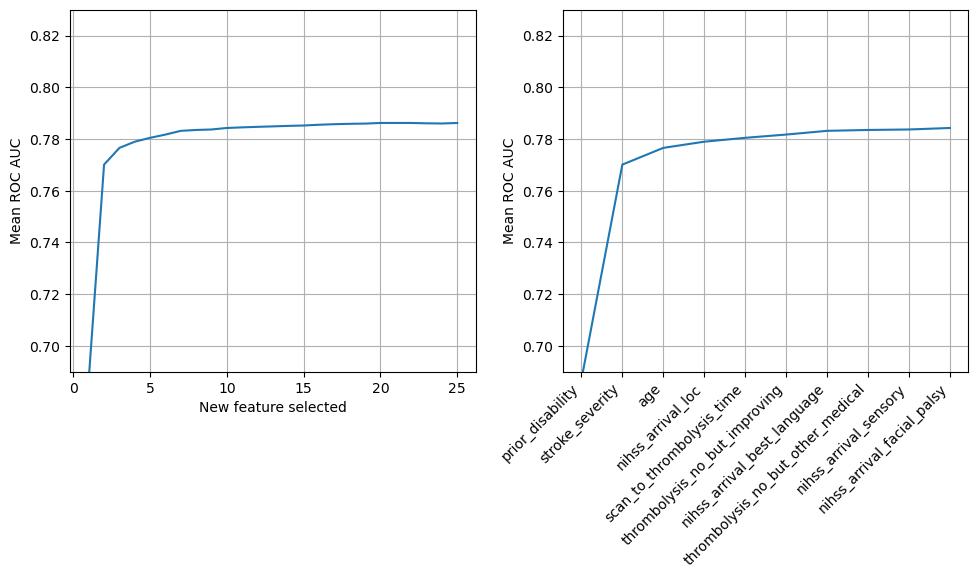

In [36]:
features_to_show = 10

fig = plt.figure(figsize=(10,6))

ax1 = fig.add_subplot(121)
ax1.plot(results['number_features'], results['AUC'])
ax1.set_xlabel('Number of features')
ax1.set_ylabel('Mean ROC AUC')
ax1.set_ylim(0.69, 0.83)
ax1.grid()

ax2 = fig.add_subplot(122)
ax2.plot(results['feature'][:features_to_show],
         results['AUC'][:features_to_show])
xlabels = list(results['feature'])
xlabels = xlabels[:features_to_show]
ax2.set_xticklabels(xlabels, rotation=45, ha='right')
ax2.set_ylabel('Mean ROC AUC')
ax1.set_xlabel('New feature selected')
ax2.set_ylim(0.69, 0.83)
ax2.grid()

plt.tight_layout(pad=1.5)

filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + '_feature_selection.jpg'))
plt.savefig(filename, dpi=300)
plt.show()

Save dictionary as a json (to be read in and used by the other notebooks).

In [37]:
feature_name_dict = {
    "prior_disability": "Prior disability level",
    "stroke_severity": "Stroke severity",
    "stroke_team": "Stroke team",
    "age": "Age",
    "year": "Year",
    "nihss_arrival_loc": "NIHSS arrival loc",
    "scan_to_thrombolysis_time": "Scan-to-thrombolysis time",
    "thrombolysis_no_but_improving": "Thrombolysis-No but improving",
    "nihss_arrival_motor_arm_left": "NIHSS arrival motor arm left",
    "nihss_arrival_best_gaze": "NIHSS arrival best gaze",
    "nihss_arrival_motor_arm_right": "NIHSS arrival motor arm right",
    "male": "Male",
    "month": "Month",
    "nihss_arrival_dysarthria": "NIHSS arrival dysarthria",
    "infarction": "Infarction",
    "arrive_by_ambulance": "Arrive by ambulance",
    "thrombolysis_no_but_too_mild_severe": "Thrombolysis-No but too mild severe",
    "diabetes": "Diabetes",
    "thrombolysis_no_but_haemorrhagic": "Thrombolysis-No but haemorrhagic",
    "nihss_arrival_motor_leg_right": "NIHSS arrival motor leg right",
    "nihss_arrival_sensory": "NIHSS arrival sensory",
    "afib_antiplatelet": "AFIB antiplatelet",
    "thrombolysis_no_but_other_medical": "Thrombolysis-No but other medical",
    "nihss_arrival_best_language": "NIHSS arrival best language",
    "congestive_heart_failure": "Congestive heart failure"
}

In [38]:
filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + '_feature_name_dict.json'))

with open(filename, "w+") as f:
    json.dump(feature_name_dict, f)

In [39]:
end_time = time.time()

print(f'Time taken: {end_time - start_time}')

Time taken: 62619.94206285477
